In [1]:
import pickle
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from models.EncoderDecoderHardMonoBig import Encoder, Decoder
import pyarrow.parquet as pq
from datasets.dataOps import create_ood_datasets, create_dataloaders
from utils.utilities import load_checkpoint
from utils.metrics import IntegratedEvaluator

# Import IDs

In [2]:
table = pq.read_table("data/info_ts.parquet")
ids = table.to_pandas().index.to_list()

In [3]:
data = {}
for array in ["static_data", "before_ts", "after_ts", "target_ts", "mask_target", "cat_dicos"]:
        with open(f"data/{array}.pkl", "rb") as f:
            data[array] = pickle.load(f)

ood_eliminate_train_val = pd.read_csv("data/entire_ood_train.csv")["id"].to_list()
ood_test = pd.read_csv("data/entire_ood_test.csv")["id"].to_list()

In [4]:
hyperparameters = {
# Static encoder parameters
"static_input_dim": 9,
"list_unic_cat": [len(dico.keys()) for dico in data["cat_dicos"].values()],
"embedding_dims": [150, 150, 150, 150],
"hidden_dim_static_encoder": 256,

# Dynamic encoder parameters
"dynamic_input_dim": 7,
"hidden_dim_dynamic_encoder": 384,
"first_decoder_input_dim": 11,
"gru_encoder_num_layers": 2,

# Decoder parameters
"gru_input_dim": 11,
"gru_hidden_dim": 384 + 256,  # hidden_dim_dynamic_encoder + hidden_dim_static_encoder
"stepwise_input_dim": 7,
"main_hidden_dim": 256,
"mask_hidden_dim": 256,
"output_dim": 11,
"monotonic_indices": [0, 2, 3, 4, 5, 6],
"gru_decoder_num_layers": 2,

# Training cycle parameters
"batch_size": 64,
"teacher_forcing_ratio": 0.7,
"max_norm": 1.0,
"learning_rate": 1e-4,
"num_epochs": 60,
"alpha": 0.7,
"beta": 0.15,
"gamma": 0.15,
}

In [5]:
train_dataset, val_dataset, test_dataset = create_ood_datasets(ids=ids,
                                                               static_data=data["static_data"],
                                                               before_ts=data["before_ts"],
                                                               after_ts=data["after_ts"],
                                                               target_ts=data["target_ts"],
                                                               mask_target=data["mask_target"],
                                                               ids_to_eliminate_of_train_validation=ood_eliminate_train_val,
                                                               test_ids=ood_test,
                                                               train_size=0.8,
                                                               val_size=0.2,
                                                               raw_data_folder="data/",
                                                               means_and_stds_path="data/work_data/means_and_stds_ood.pkl",
                                                               )

train_loader, val_loader, test_loader = create_dataloaders(train_dataset,
                                                           val_dataset,
                                                           test_dataset,
                                                           batch_size=hyperparameters["batch_size"])


          Train_DS = 128900 obs
          Val_DS = 32225 obs
          Test_DS = 2864 obs
          


In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
torch.manual_seed(42)

encoder = Encoder(static_input_dim=hyperparameters["static_input_dim"],
                  static_hidden_dim=hyperparameters["hidden_dim_static_encoder"],
                  list_unic_cat=hyperparameters["list_unic_cat"],
                  embedding_dims=hyperparameters["embedding_dims"],
                  dynamic_input_dim=hyperparameters["dynamic_input_dim"],
                  dynamic_hidden_dim=hyperparameters["hidden_dim_dynamic_encoder"],
                  first_decoder_input_dim=hyperparameters["first_decoder_input_dim"],
                  gru_num_layers=hyperparameters["gru_encoder_num_layers"],
                  ).to(device)

decoder = Decoder(gru_input_dim=hyperparameters["gru_input_dim"],
                  gru_hidden_dim=hyperparameters["gru_hidden_dim"],
                  stepwise_input_dim=hyperparameters["stepwise_input_dim"],
                  main_hidden_dim=hyperparameters["main_hidden_dim"],
                  output_dim=hyperparameters["output_dim"],
                  monotonic_indices=hyperparameters["monotonic_indices"],
                  num_layers=hyperparameters["gru_decoder_num_layers"]
                  ).to(device)

optimizer = torch.optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=0.001)


Using device: cuda


In [7]:
checkpoint = torch.load("checkpoints/12_OOD_non_physical_HardWiredBIG_60_eps/best_model.pth")
load_checkpoint(checkpoint,
                encoder,
                decoder,
                optimizer)

=== Loading checkpoint ===


In [8]:
# Import Means and Standard Deviations
with open("data/work_data/means_and_stds_ood.pkl", "rb") as f:
    means_and_stds = pickle.load(f)

In [9]:
encoder.eval()
decoder.eval()

with torch.no_grad():
    batch_hat_target = []
    batch_hat_mask = []
    batch_target = []
    batch_mask = []
    ids = []
    for batch in test_loader:
        ids.append(batch["id"])
        static_data_cat = batch["static_data_cat"].to(device)
        static_data_num = batch["static_data_num"].to(device)
        before_ts = batch["before_ts"].to(device)
        after_ts = batch["after_ts"].to(device)
        target_ts = batch["target_ts"].to(device)
        mask_target = batch["mask_target"].to(device)

        latent, x_t = encoder(static_data_num, static_data_cat, before_ts)
        h_t = latent
        generated_ts = [] 
        for t in range(after_ts.shape[1]):
            output, h_t, h_output = decoder(x_t.unsqueeze(1), h_t, after_ts[:, t, :])
            x_t = output
            generated_ts.append(output)

        batch_hat_target.append((torch.stack(generated_ts, dim=1).to("cpu") * means_and_stds["target_ts_std"]) + means_and_stds["target_ts_mean"])
        batch_target.append((target_ts.to("cpu") * means_and_stds["target_ts_std"]) + means_and_stds["target_ts_mean"])
        # batch_hat_target.append(torch.stack(generated_ts, dim=1))
        # batch_target.append(target_ts)
        batch_mask.append(mask_target)
    # all_ts = torch.stack(batch_ts, dim=1)
    # all_mask = torch.stack(batch_mask, dim=1)

/tmp/ipykernel_3674084/3389845642.py:27: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  batch_hat_target.append((torch.stack(generated_ts, dim=1).to("cpu") * means_and_stds["target_ts_std"]) + means_and_stds["target_ts_mean"])
/tmp/ipykernel_3674084/3389845642.py:28: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  batch_target.append((target_ts.to("cpu") * means_and_stds["target_ts_std"]) + means_and_stds["target_ts_mean"])


In [10]:
print(batch_target[0].shape, batch_hat_target[0].shape)

torch.Size([128, 200, 11]) torch.Size([128, 200, 11])


In [11]:
print(len(batch_mask))

23


In [12]:
batch_hat_target[0][0].shape

torch.Size([200, 11])

00fb79f5-82ea-4fb1-b743-c12b24a6f29f


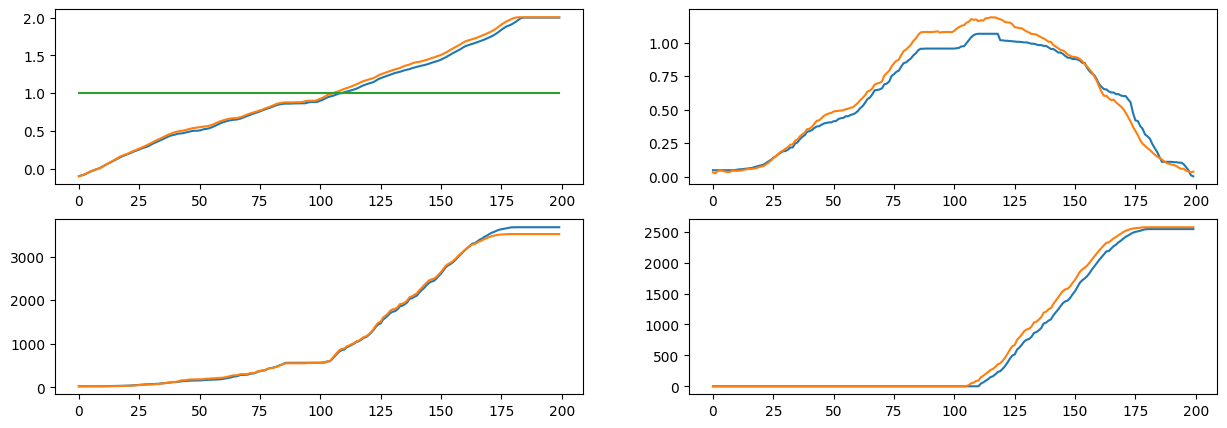

In [13]:
fig, ax = plt.subplots(2, 2, figsize=(15, 5))
i = 8
print(ids[0][i])
sns.lineplot(batch_target[0][i][:,0].to("cpu").numpy(), ax=ax[0, 0])
sns.lineplot(batch_hat_target[0][i][:,0].to("cpu").numpy(), ax=ax[0, 0])
sns.lineplot(batch_mask[0][i][:,0].to("cpu").numpy(), ax=ax[0, 0])
sns.lineplot(batch_target[0][i][:,1].to("cpu").numpy(), ax=ax[0, 1])
sns.lineplot(batch_hat_target[0][i][:,1].to("cpu").numpy(), ax=ax[0, 1])
sns.lineplot(batch_target[0][i][:,2].to("cpu").numpy(), ax=ax[1, 0])
sns.lineplot(batch_hat_target[0][i][:,2].to("cpu").numpy(), ax=ax[1, 0])
sns.lineplot(batch_target[0][i][:,3].to("cpu").numpy(), ax=ax[1, 1])
sns.lineplot(batch_hat_target[0][i][:,3].to("cpu").numpy(), ax=ax[1, 1])
plt.show()

In [14]:
concat_batch_hat_target = torch.cat(batch_hat_target, dim=0).to("cpu")
concat_batch_target = torch.cat(batch_target, dim=0).to("cpu")
concat_real_mask = torch.cat(batch_mask, dim=0).to("cpu")

In [15]:
concat_real_mask.squeeze(2).numpy()

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]], dtype=int8)

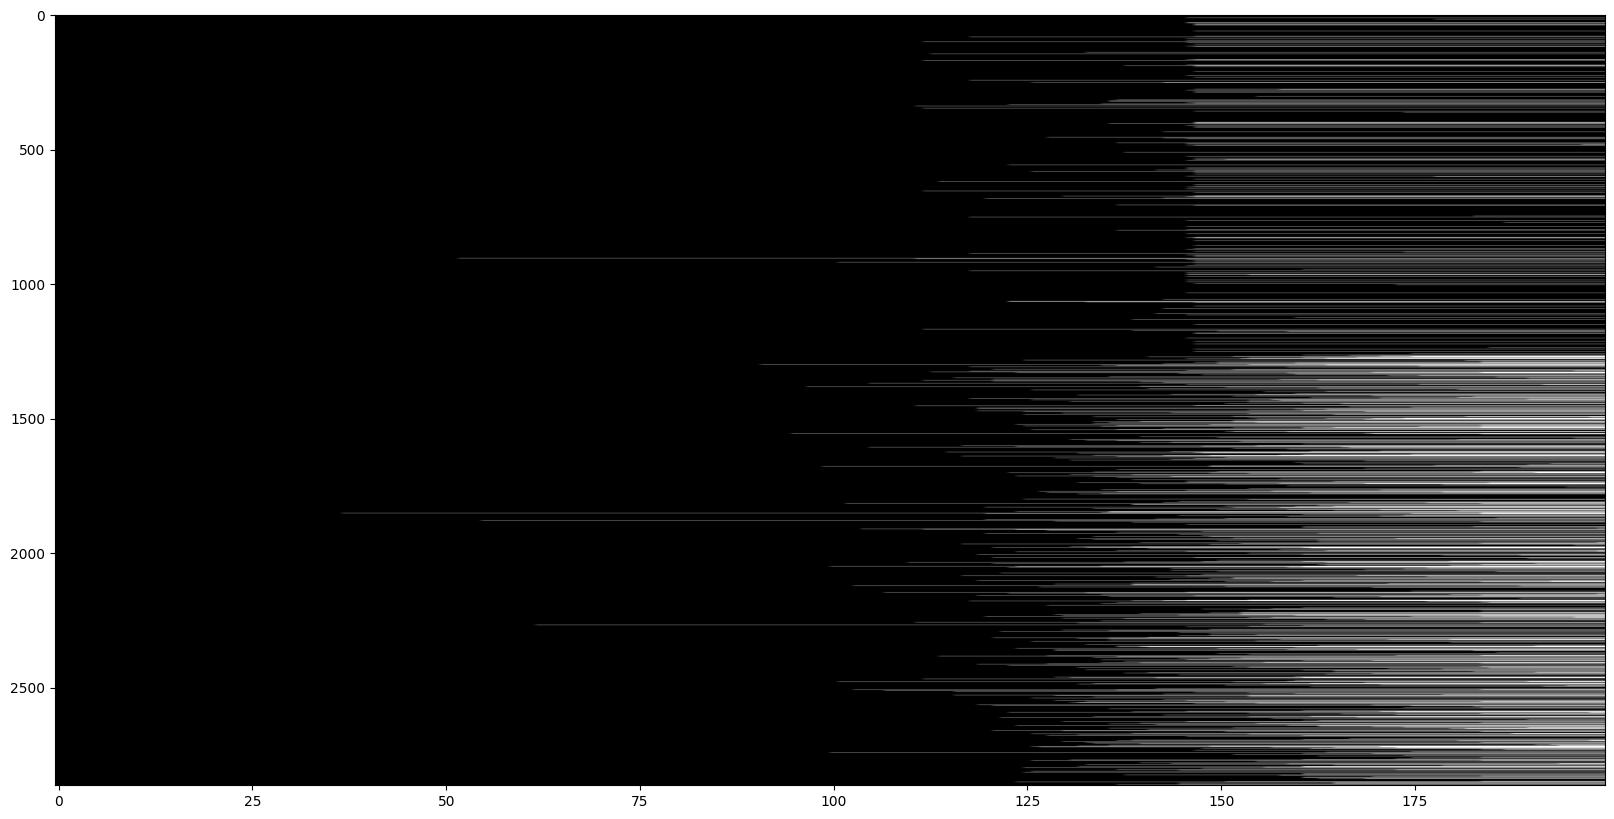

In [16]:
# Do a graphic of concat_real_mask when one line is an observation, then 1 is black, 0 is white
fig, ax = plt.subplots(figsize=(20, 10))
ax.imshow(concat_real_mask.squeeze(2).numpy(), aspect="auto", cmap="binary")
plt.show()

In [17]:
# find the maximum value index

cosa = abs((concat_batch_hat_target*concat_real_mask)-(concat_batch_target*concat_real_mask))

x_flat = cosa.view(-1)

# Get index of max value
max_index = x_flat.argmax()

# Convert flat index back to multi-dimensional index
max_position = torch.unravel_index(max_index, cosa.shape)

In [18]:
x_flat[max_index].item()

17050.666908985608

In [19]:
max_position

(tensor(1855), tensor(183), tensor(2))

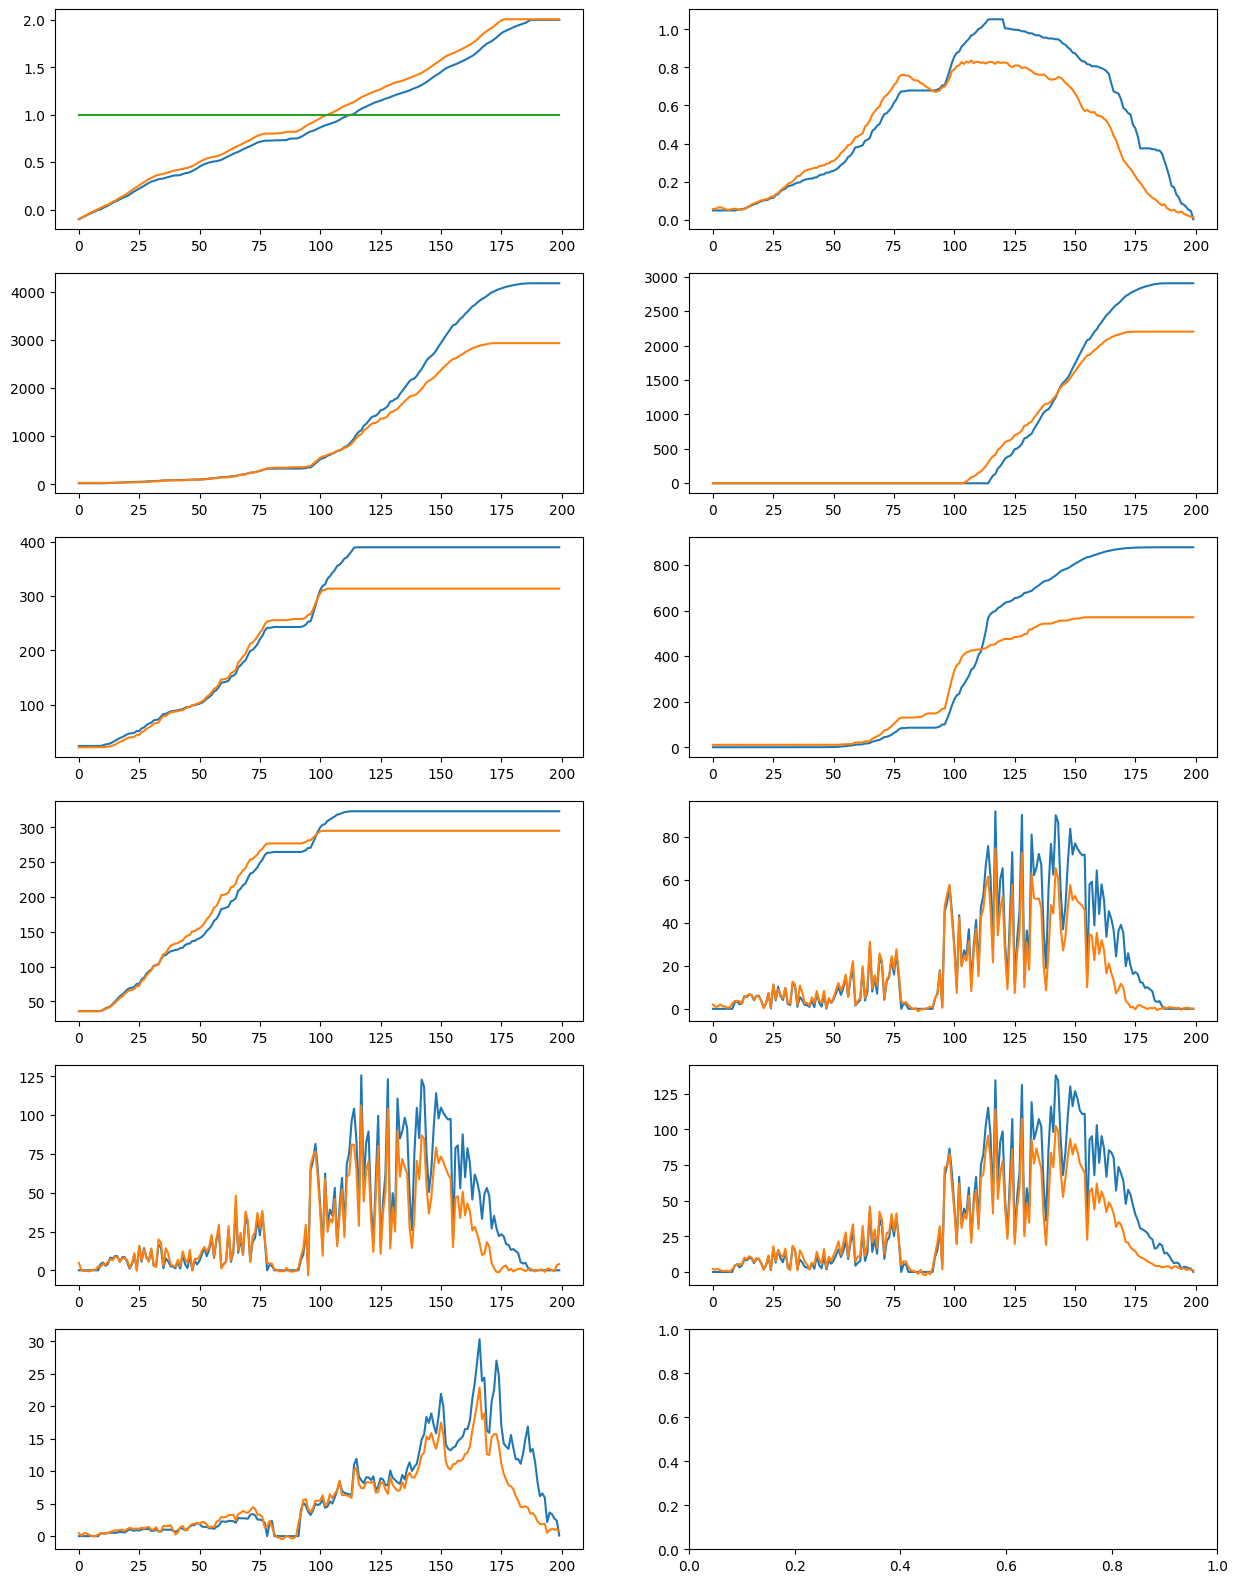

In [20]:
fig, ax = plt.subplots(6, 2, figsize=(15, 20))
i = 1000
sns.lineplot(concat_batch_target[i][:,0].to("cpu").numpy(), ax=ax[0, 0])
sns.lineplot(concat_batch_hat_target[i][:,0].to("cpu").numpy(), ax=ax[0, 0])
sns.lineplot(concat_real_mask[i][:,0].to("cpu").numpy(), ax=ax[0, 0])
sns.lineplot(concat_batch_target[i][:,1].to("cpu").numpy(), ax=ax[0, 1])
sns.lineplot(concat_batch_hat_target[i][:,1].to("cpu").numpy(), ax=ax[0, 1])
sns.lineplot(concat_batch_target[i][:,2].to("cpu").numpy(), ax=ax[1, 0])
sns.lineplot(concat_batch_hat_target[i][:,2].to("cpu").numpy(), ax=ax[1, 0])
sns.lineplot(concat_batch_target[i][:,3].to("cpu").numpy(), ax=ax[1, 1])
sns.lineplot(concat_batch_hat_target[i][:,3].to("cpu").numpy(), ax=ax[1, 1])
sns.lineplot(concat_batch_target[i][:,4].to("cpu").numpy(), ax=ax[2, 0])
sns.lineplot(concat_batch_hat_target[i][:,4].to("cpu").numpy(), ax=ax[2, 0])
sns.lineplot(concat_batch_target[i][:,5].to("cpu").numpy(), ax=ax[2, 1])
sns.lineplot(concat_batch_hat_target[i][:,5].to("cpu").numpy(), ax=ax[2, 1])
sns.lineplot(concat_batch_target[i][:,6].to("cpu").numpy(), ax=ax[3, 0])
sns.lineplot(concat_batch_hat_target[i][:,6].to("cpu").numpy(), ax=ax[3, 0])
sns.lineplot(concat_batch_target[i][:,7].to("cpu").numpy(), ax=ax[3, 1])
sns.lineplot(concat_batch_hat_target[i][:,7].to("cpu").numpy(), ax=ax[3, 1])
sns.lineplot(concat_batch_target[i][:,8].to("cpu").numpy(), ax=ax[4, 0])
sns.lineplot(concat_batch_hat_target[i][:,8].to("cpu").numpy(), ax=ax[4, 0])
sns.lineplot(concat_batch_target[i][:,9].to("cpu").numpy(), ax=ax[4, 1])
sns.lineplot(concat_batch_hat_target[i][:,9].to("cpu").numpy(), ax=ax[4, 1])
sns.lineplot(concat_batch_target[i][:,10].to("cpu").numpy(), ax=ax[5, 0])
sns.lineplot(concat_batch_hat_target[i][:,10].to("cpu").numpy(), ax=ax[5, 0])
plt.show()

In [21]:
concat_batch_target.shape

torch.Size([2864, 200, 11])

In [22]:
evaluator = IntegratedEvaluator(y_true=concat_batch_target.numpy(),
                                y_pred=concat_batch_hat_target.numpy(),
                                mask=concat_real_mask.squeeze(-1).numpy()
                                )

In [23]:
print(evaluator.to_dataframe())

                 MAE         RMSE        R2      MASE  MonoViolation  \
Variable                                                               
Var_0       0.031321     0.060861  0.990432  0.093427       0.000000   
Var_1       0.196477     0.471087  0.932781  0.155046       0.462312   
Var_2     426.410929  1221.990003  0.951780  0.126406       0.000000   
Var_3     226.744978   764.931844  0.895031  0.195307       0.000000   
Var_4      79.978212   189.321880  0.977367  0.099532       0.000000   
Var_5     169.182015   485.738292  0.964094  0.108778       0.000000   
Var_6      46.404448    99.120137  0.979461  0.097734       0.000000   
Var_7       9.768755    32.924229  0.886655  0.131769       0.497487   
Var_8      14.202628    48.560152  0.886577  0.131297       0.492462   
Var_9      18.046747    59.987777  0.889613  0.132959       0.477387   
Var_10      4.696805    19.203927  0.857583  0.143236       0.497487   

             Biomass     Assim     Matter  
Variable           

In [24]:
evaluator.summary()

{'MAE': 90.51484684060647,
 'RMSE': 265.66456259012756,
 'R2': 0.9283068149904328,
 'MASE': 0.12868094751604842,
 'MonoViolation': 0.2206486980356327,
 'Biomass': 116.73949228160478,
 'Assim': 0.3647412361812728,
 'Matter': 25.54710783975837}

In [25]:
evaluator.evaluate_last_timestep()

,MAE,RMSE,R2
Variable,,,
Var_0,0.038616,0.082888,0.964970
Var_1,0.235495,0.437324,0.969179
Var_2,712.733058,1204.689900,0.911254
Var_3,471.094947,908.010816,0.855954
Var_4,116.774723,195.467320,0.974820
Var_5,242.861494,410.590904,0.969412
Var_6,67.160577,116.361168,0.942252
Var_7,17.188727,49.767347,0.812623
Var_8,24.434336,71.443289,0.815894
